<a href="https://colab.research.google.com/github/Bibi852/jhu-ml/blob/main/Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More Classification and CV HW



> <b>Author</b>: Abigail Lee



## Exercise 1

Cross-validation is a technique used to assess models in statistics and machine learning. Instead of fitting a model once with a single training and testing set, cross-validation repeats this process multiple times using several randomly split subsets. The results are then aggregated for more accurate and reliable measures of model performance compared to the single value obtained through a traditional train-test split method. Moreover, by using every observation in model development and evaluation, this method makes the most of small amounts of data, a common limitation when studying real-world phenomena.

## Exercise 2

  
Bootstrapping is a powerful tool for data analysis in nontraditional scenarios where standard statistical methods may not apply. There is no way to calculate a standard error for metrics like percentiles or medians, and real-world limitations like small amounts of data or non-normal distributions violate the assumptions made in parametric statistics. Yet, by simulating results from tens of thousands of resampled sets from the group of observations, bootstrapping effectively reconstructs the sampling distribution assumed in traditional statistics, thus allowing statisticians to manually calculate measures of precision like the standard error or confidence intervals.

## Exercise 3

### Importing Packages and Dataset

In [ ]:
pip install ISLP

In [ ]:
# importing modules from ISLP textbook
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA ,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import random
from IPython.display import Markdown

In [155]:
# importing Auto dataset
random.seed(42)
Auto = load_data('Auto')
Auto.columns
Auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [156]:
# creating binary variable mpg01 to classify observations based on whether
# their mpg value was above or below the median
mpg01 = Auto.mpg > Auto['mpg'].median()
# including new variable in original dataset
Auto['mpg01'] = mpg01

### Preliminary Explorations

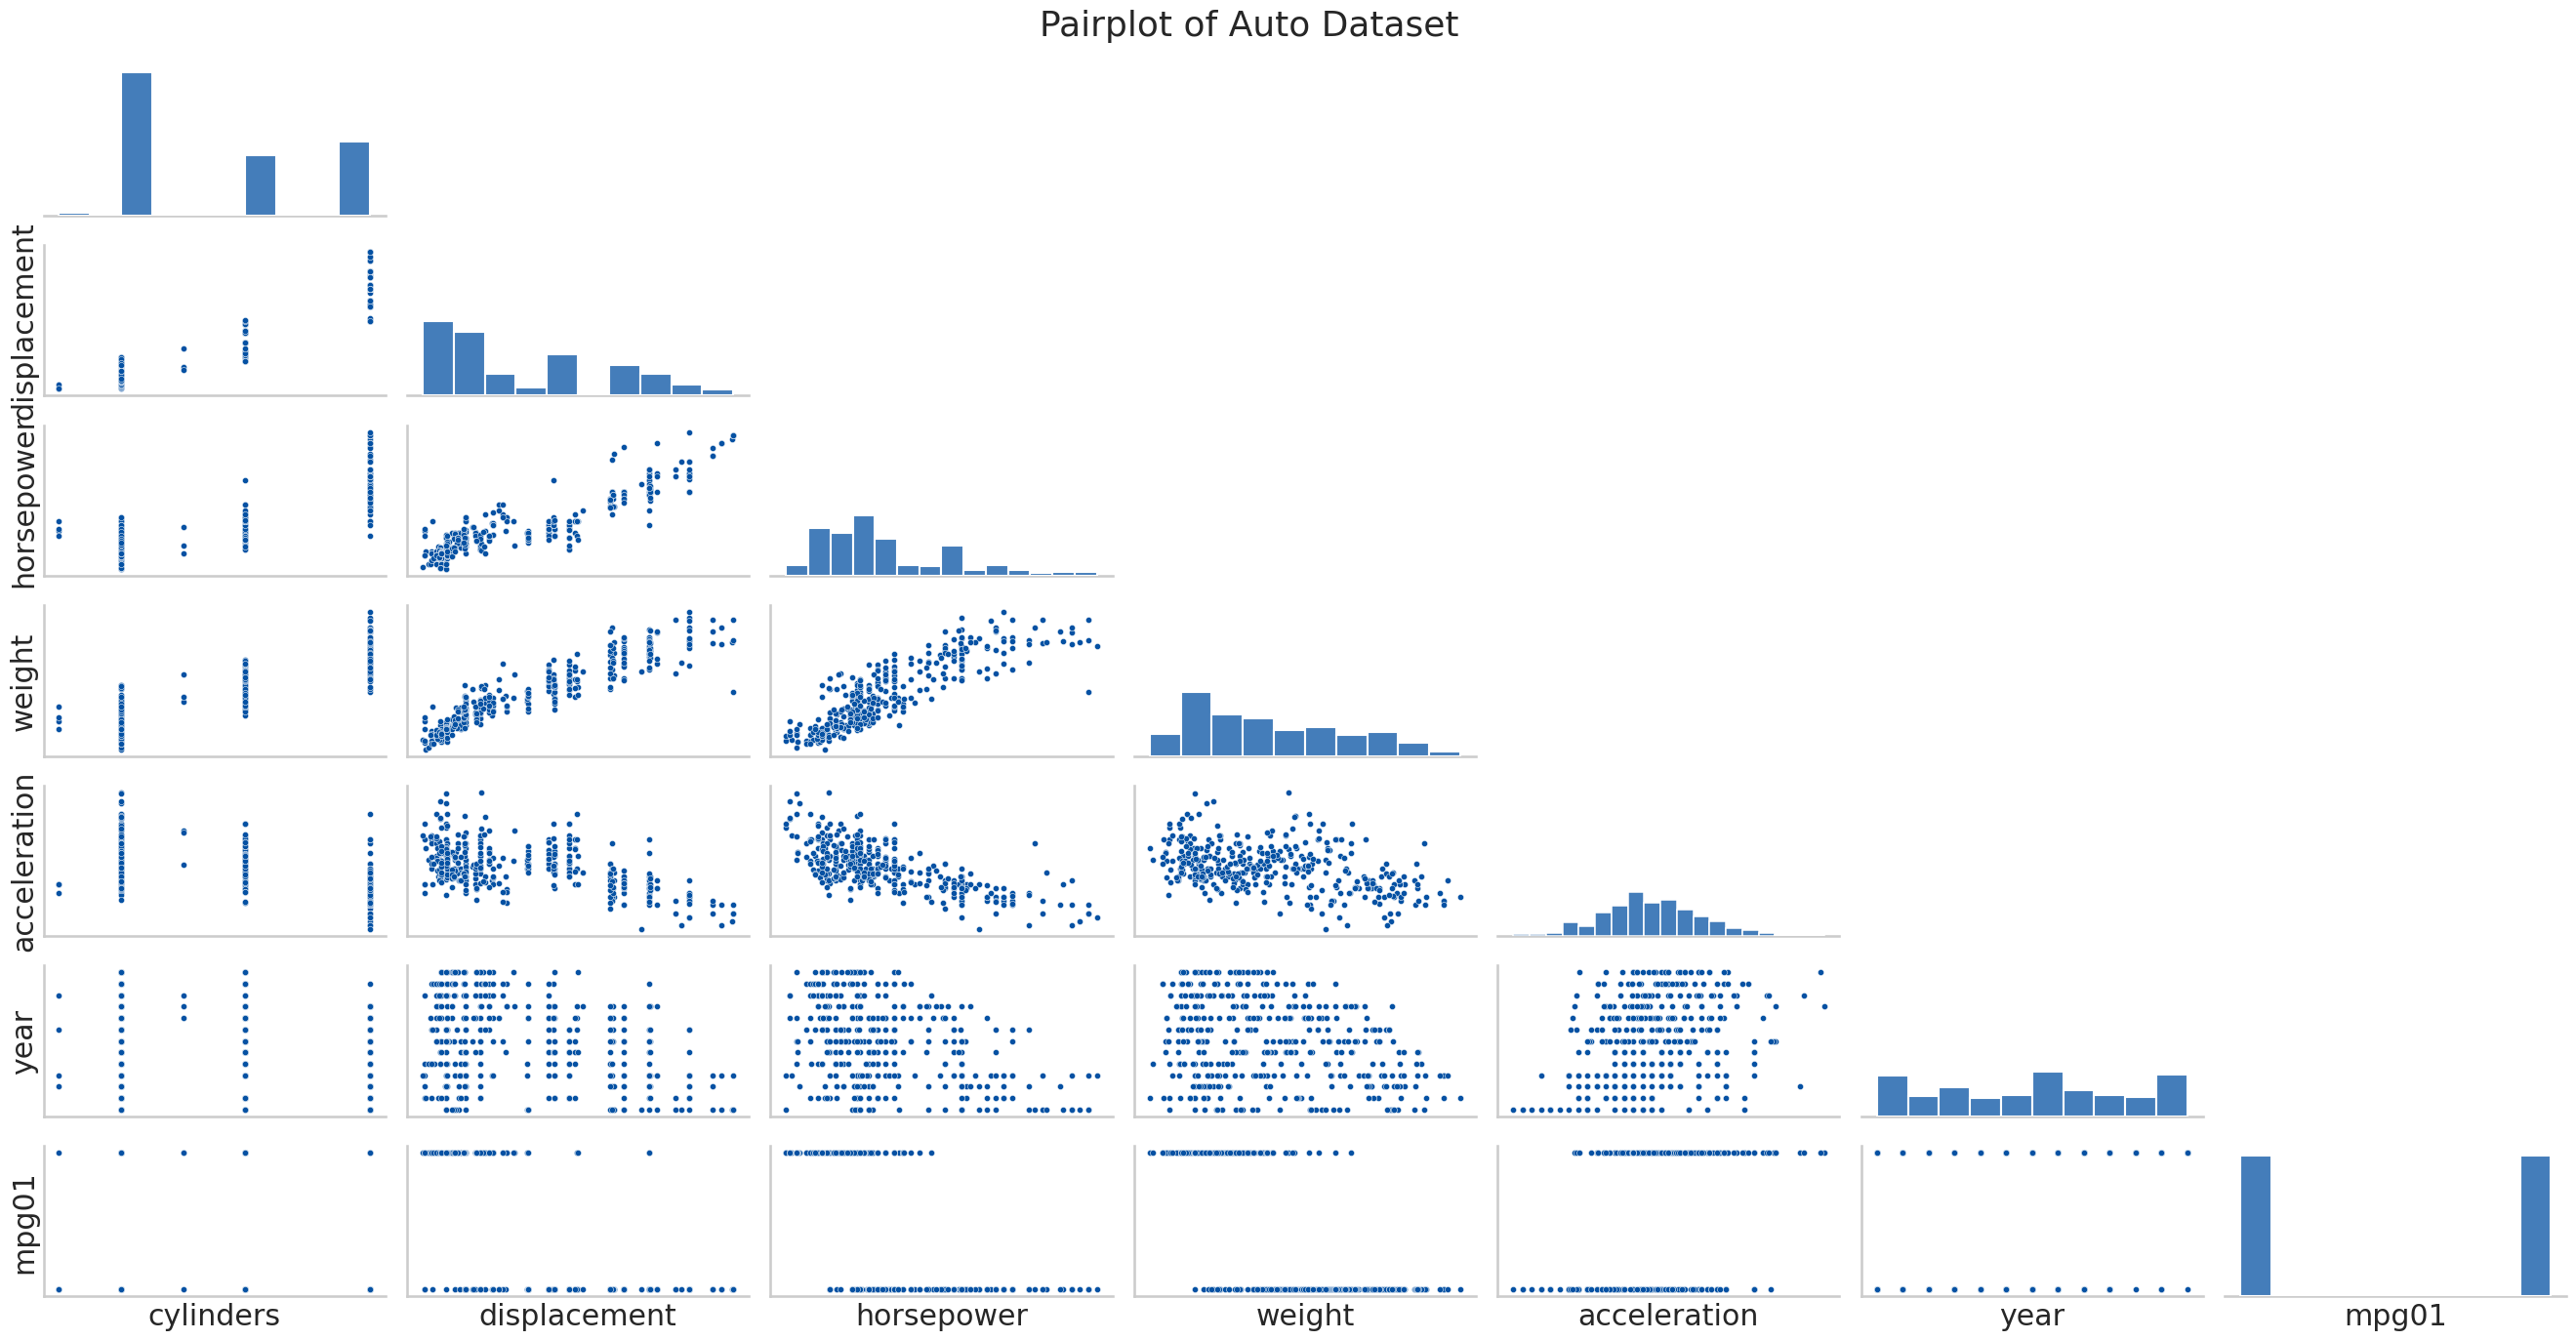

In [150]:
# exploring associations between outcome variable and other features
# using seaborn to make scatterplot matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.2)
# origin is a discrete variable and mpg is not needed since we are interested in the binary variable of high/low MPG
# pairplot matrix to explore correlations between features and outcomes
fullplot = sns.pairplot(Auto.drop(columns = ['mpg', 'origin']),
                        corner = True, height=2, aspect=2, plot_kws={'s': 20,
                                                                       'color':'#0551A3'},
                        diag_kws = {'color': '#0551A3'}
                     )

fullplot.fig.suptitle('Pairplot of Auto Dataset', y = 1.02)
fullplot.set(xticks=[], yticks = [])
# taken from code documentation
plt.show()





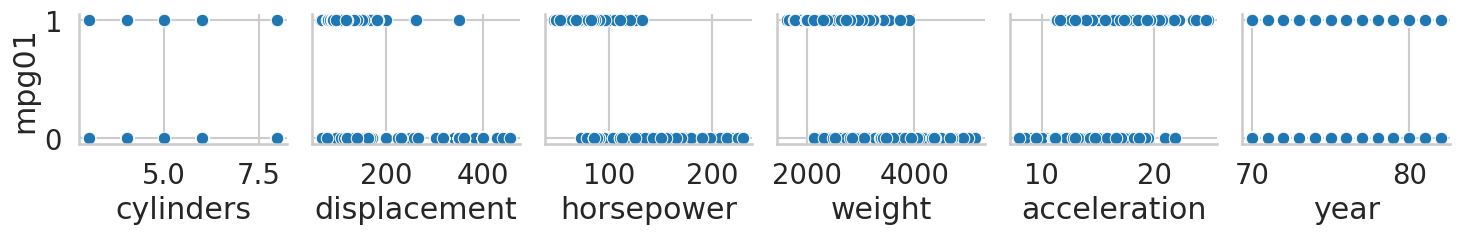

In [ ]:
closeup = sns.pairplot(Auto, x_vars = Auto.columns.drop(['mpg', 'origin','mpg01']),
                     y_vars = ['mpg01']
                     )

Because `mpg01` is a binary variable, the scatterplots do not give easily interpretable insights on its relationship with other features. However, we can see that many features correlated with `mpg01` (as specified in the below correlation matrix) are also correlated with each other, which may pose a problem for inference but is not as great a concern in the current objective of prediction.

In [106]:
# mpg variable is redundant as it shares perfect collinearity with new variable mpg01
Auto.drop(columns=['mpg']).corr()

,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
cylinders,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932,-0.759194
displacement,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535,-0.753477
horsepower,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171,-0.667053
weight,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005,-0.757757
acceleration,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746,0.346822
year,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528,0.429904
origin,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000,0.513698
mpg01,-0.759194,-0.753477,-0.667053,-0.757757,0.346822,0.429904,0.513698,1.000000


In [107]:
# melting auto df to make facetted boxplots
# dropping mpg variable as this is redundant, dropping name and origin as these
# are discrete variables
automelt = pd.melt(Auto.reset_index().drop(columns=['mpg', 'name', 'origin']),
        id_vars = ['mpg01'],
        var_name = 'variable',
        value_name = 'value')

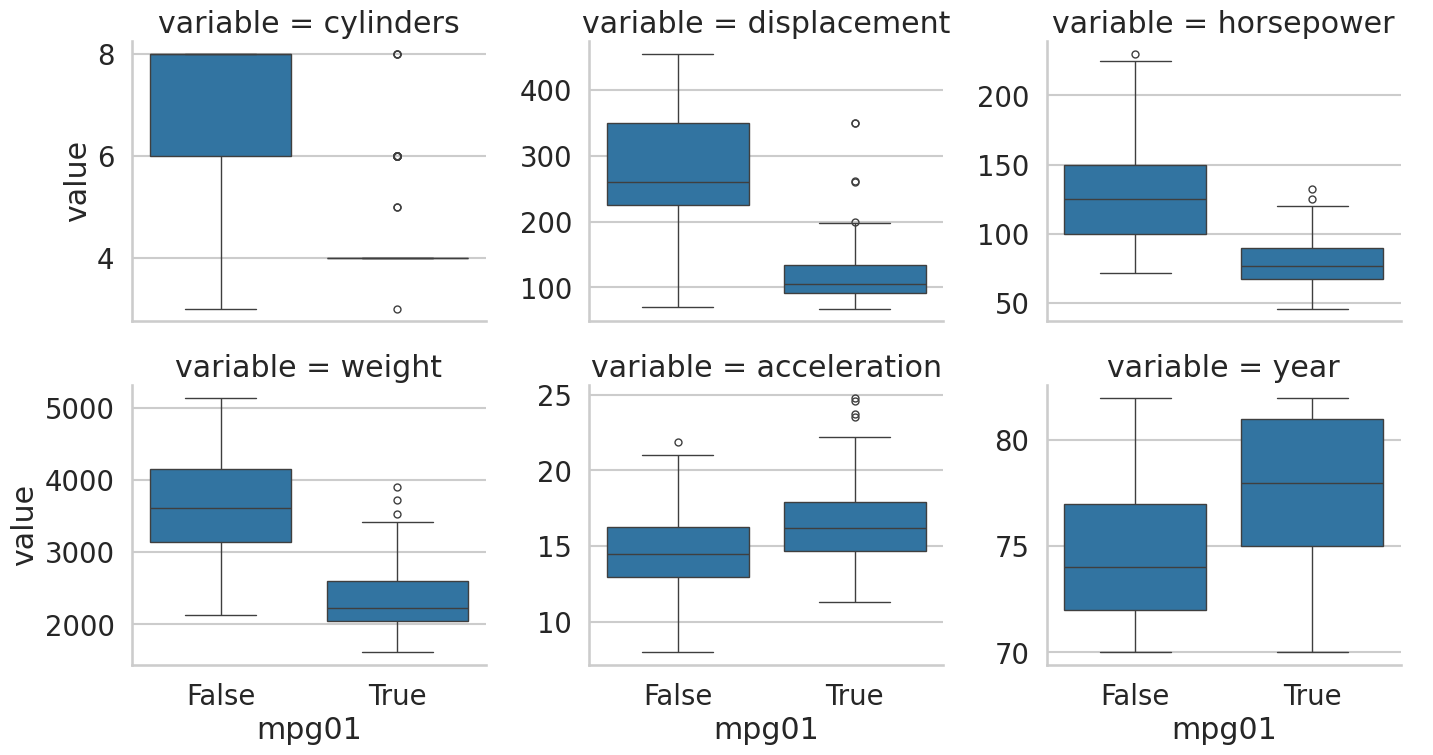

In [ ]:
sns.catplot(
    data = automelt, x = 'mpg01', y = 'value',
    col = 'variable', kind = 'box', col_wrap = 3,
    sharey = False, height = 4, aspect = 1.2
)



> Catplot code documentation based on stack overflow post https://stackoverflow.com/questions/52472757/creating-a-boxplot-facetgrid-in-seaborn-for-python



Looking at the boxplots of each numeric feature by `mpg01` category, the distributions of `cylinders`, `displacement`, `weight`, and `horsepower` seem to be substantially different for observations with `mpg` values above and below the median. These variables will be the focus of the classification models explored next.

### Splitting Data

In [157]:
# subset of relevant variables
feature_df = Auto[['cylinders', 'displacement', 'weight', 'horsepower']]

In [158]:
# splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_df, mpg01, test_size = 0.3, random_state = 42)


### Linear Discriminant Analysis

In [159]:
lda = LDA(store_covariance = True)

In [160]:
# fitting LDA model on training set
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [161]:

lda_coef = pd.DataFrame(lda.coef_, columns = feature_df.columns)
lda_coef

,cylinders,displacement,weight,horsepower
0,-1.474176,-0.005806,-0.002051,0.007084


I used Linear Discriminant Analysis (LDA) to classify observations with `mpg` values above or below the median based on the variables `cylinders`, `displacement`, `weight`, and `horsepower`. Out of these variables, `cylinders` contributes the most to class separation, and more specifically, a greater amount of cylinders is associated with a smaller likelihood that a car has an above-average miles per gallon value.

In [162]:
# covariance matrix across classes
pd.DataFrame(lda.covariance_, columns = feature_df.columns, index = feature_df.columns)

,cylinders,displacement,weight,horsepower
cylinders,1.109561,60.136883,409.802480,19.677463
displacement,60.136883,4174.167976,28422.748704,1368.402699
weight,409.802480,28422.748704,285212.617933,10178.739165
horsepower,19.677463,1368.402699,10178.739165,750.821928


Vehicle weight has the highest variance across classes. All features trend to increase/decrease together, and vehicle weight in particular shares strong correlations with engine cylinders, displacement and horsepower.

In [114]:
## test accuracy function taken from last assignment

# more specific accuracy rates given a confusion table
def further_acc(ct):
  # overall accuracy rate = (n of correct classifications)/n of total classifications
  overall_acc = (ct.loc[True, True] + ct.loc[False, False])/(ct.sum().sum())
  # positive accuracy rate = (n of correct positive predictions)/(total n of positive predictions)
  pos_acc = ct.loc[True, True]/ct.loc[True].sum()
  # negative accuracy rate = (n of correct negative predictions)/(total n of negative predictions)
  neg_acc = ct.loc[False, False]/ct.loc[False].sum()
  return overall_acc, pos_acc, neg_acc

In [171]:
# using fitted model to predict observations in unseen test set
lda_pred = lda.predict(X_test)
overall_acc, pos_acc, neg_acc = further_acc(confusion_table(lda_pred, y_test))
test_error = 1 - overall_acc

In [164]:
confusion_table(lda_pred, y_test)

Truth,False,True
Predicted,,
False,51,2
True,14,51


In [172]:
Markdown(
    " Using LDA, I am able to distinguish cars with high and low fuel mileage at an accuracy of {overall_acc:.3f} (error rate is {test_error:.3f}). The model classifies cars with above median mileage at a {pos_acc:.3f} accuracy rate while it accurately identifies {neg_acc:.3f} of cars with low mileage.".format(overall_acc = overall_acc, test_error = test_error, pos_acc = pos_acc, neg_acc = neg_acc)
)

 Using LDA, I am able to distinguish cars with high and low fuel mileage at an accuracy of 0.864 (error rate is 0.136). The model classifies cars with above median mileage at a 0.785 accuracy rate while it accurately identifies 0.962 of cars with low mileage.

### Quadratic Discriminant Analysis

In [165]:
# qda model
qda = QDA(store_covariance = True)
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [166]:
pd.DataFrame(qda.means_, columns = feature_df.columns,
             index = ['Below', 'Above'])

,cylinders,displacement,weight,horsepower
Below,6.908397,281.641221,3660.442748,132.488550
Above,4.202797,118.972028,2369.083916,79.594406


Average amount of cylinders, engine displacement, vehicle weight, and engine horsepower are all higher in the class of vehicles with `mpg` values below the median.

In [167]:
pd.DataFrame(qda.covariance_[0], columns = feature_df.columns,
             index = feature_df.columns)

,cylinders,displacement,weight,horsepower
cylinders,1.745390,99.059190,667.440869,35.906635
displacement,99.059190,6826.462595,43584.460070,2435.938168
weight,667.440869,43584.460070,413160.140928,16790.828186
horsepower,35.906635,2435.938168,16790.828186,1291.697945


In [168]:
pd.DataFrame(qda.covariance_[1], columns = feature_df.columns,
             index = feature_df.columns)

,cylinders,displacement,weight,horsepower
cylinders,0.543091,25.350783,179.708214,5.096917
displacement,25.350783,1804.802029,14942.629124,410.354772
weight,179.708214,14942.629124,172094.640796,4268.780754
horsepower,5.096917,410.354772,4268.780754,266.228701


QDA does not assume equal covariance matrices across classes so that non-linear decision boundaries are possible. Thus, we can analyze differences in variance when `mpg` is above or below the median. While on average, there is less spread and weaker covariance in the above-average `mpg` class, vehicle weight still has the highest variance across classes and is the most strongly correlated with other vehicle/engine features.

In [169]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, y_test)


Truth,False,True
Predicted,,
False,51,3
True,14,50


In [174]:
overall_acc, pos_acc, neg_acc = further_acc(confusion_table(qda_pred, y_test))
test_error = 1 - overall_acc
Markdown(
    """ QDA performs slightly worse than LDA at classifying high and low mileage cars, achieving a {overall_acc:.3f} accuracy ({test_error:.3f} error rate).
    Low mileage cars were classified at {neg_acc:.3f} accuracy while only {pos_acc:.3f} of the model's high fuel mileage predictions were correct.
    The variance and covariance in feature distribution is actually quite similar between both classes, so the added complexity of QDA may have actually weakened
    its generalization to new data. """.format(overall_acc = overall_acc, test_error = test_error, neg_acc = neg_acc, pos_acc = pos_acc)
)

 QDA performs slightly worse than LDA at classifying high and low mileage cars, achieving a 0.856 accuracy (0.144 error rate). 
    Low mileage cars were classified at 0.944 accuracy while only 0.781 of the model's high fuel mileage predictions were correct. 
    The variance and covariance in feature distribution is actually quite similar between both classes, so the added complexity of QDA may have actually weakened 
    its generalization to new data. 

### Logistic Regression

In [130]:
glm = sm.GLM(y_train, X_train, family = sm.families.Binomial())
results = glm.fit()
# using code from last assignment
glm_probs = results.predict(exog = X_test)
labs = np.array([False]*len(X_test))
labs[glm_probs>0.5] = True
confusion_table(labs, y_test)


Truth,False,True
Predicted,,
False,45,1
True,20,52


In [136]:
Markdown(
    """ Logistic regression predicts high/low fuel mileage at a {overall_acc:.3f} rate with an error of {test_error:.3f}, which is the worst
    performance so far. Intersetingly, logistic regression returns the smallest error for low mileage classification at {neg_error:.3f} but the highest
    error for high mileage classifcation at {pos_error:.3f}. Since LDA has the best performance, followed by QDA and then logistic regression, it seems that
    even though the decision boundaries between classes is approximately linea, the strong multicollinearity between explanatory variables weakens the predictive
    power of logistic regression as it does not account for covariance like LDA or QDA does.""".format(overall_acc = overall_acc,
                                                                                                       test_error = test_error,
                                                                                                       neg_error = neg_error,
                                                                                                       pos_error = pos_error)
)

 Logistic regression predicts high/low fuel mileage at a 0.822 rate with an error of 0.178, which is the worst 
    performance so far. Intersetingly, logistic regression returns the smallest error for low mileage classification at 0.022 but the highest
    error for high mileage classifcation at 0.278. Since LDA has the best performance, followed by QDA and then logistic regression, it seems that 
    even though the decision boundaries between classes is approximately linea, the strong multicollinearity between explanatory variables weakens the predictive
    power of logistic regression as it does not account for covariance like LDA or QDA does.

### Naive Bayes

In [137]:
# fitting Naive Bayes model and predicting unseen x values
NB = GaussianNB()
NB.fit(X_train, y_train)
nb_labs = NB.predict(X_test)

In [138]:
# array of means for each class - low and high MPG, and each feature

NB.theta_

array([[   6.90839695,  281.64122137, 3660.44274809,  132.48854962],
       [   4.2027972 ,  118.97202797, 2369.08391608,   79.59440559]])

In [139]:
# returns exact same results as LDA
lda.means_

array([[   6.90839695,  281.64122137, 3660.44274809,  132.48854962],
       [   4.2027972 ,  118.97202797, 2369.08391608,   79.59440559]])

In [140]:
confusion_table(nb_labs, y_test)

Truth,False,True
Predicted,,
False,51,2
True,14,51


In [141]:
overall_acc, pos_acc, neg_acc = further_acc(confusion_table(nb_labs, y_test))
print(f'Overall test accuracy:{overall_acc}\nPositive test accuracy:{pos_acc}\nNegative test accuracy:{neg_acc}')

Overall test accuracy:0.864406779661017
Positive test accuracy:0.7846153846153846
Negative test accuracy:0.9622641509433962


Interestingly, Naive Bayes (NB) obtained identical predictive outcomes to the initial LDA model. The parameters for the features for each class are additionally the same as those calculated through LDA, indicating that class boundaries are inherently well-separated by the predictive features. If this is the case, the poor performance of the logistic regression model makes sense as according to the lectures, logistic regression is unstable when classes are already well-separated.

### K-Nearest Neighbors

In [142]:
# function for k-nearest neighbors model fitting and prediction
def knnfun(n):
  knn = KNeighborsClassifier(n_neighbors = n)
  knn_pred = knn.fit(X_train, y_train).predict(X_test)
  return knn_pred

# for loop modified from ISLP Chapter 4 lab
for K in range(1,6):
  knn_pred = knnfun(K)
  C = confusion_table(knn_pred, y_test)
  test_acc = np.mean(knn_pred == y_test)
  print(f"K={K}, test error = {1-test_acc}\ntest accuracy: {test_acc}")


K=1, test error = 0.15254237288135597
test accuracy: 0.847457627118644
K=2, test error = 0.15254237288135597
test accuracy: 0.847457627118644
K=3, test error = 0.13559322033898302
test accuracy: 0.864406779661017
K=4, test error = 0.14406779661016944
test accuracy: 0.8559322033898306
K=5, test error = 0.1610169491525424
test accuracy: 0.8389830508474576


The KNN classifier classifies high/low MPG cars at the highest accuracy when 3 neighbors are considered in classification. Interestingly, KNN at K=3 produces the same predictive results as the NB and LDA models, reinforcing the idea that the boundaries between classes are already very clear.

In [143]:
# fitting KNN model but with standardized features
scaler = StandardScaler(with_mean = True, with_std = True, copy = True)
scaler.fit(X_train)
scaler.fit(X_test)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# repeating iteration
for K in range(1,6):
  knn_pred = knnfun(K)
  C = confusion_table(knn_pred, y_test)
  test_acc = np.mean(knn_pred == y_test)
  print(f"K={K}, test error = {1-test_acc}\ntest accuracy: {test_acc}")

K=1, test error = 0.15254237288135597
test accuracy: 0.847457627118644
K=2, test error = 0.10169491525423724
test accuracy: 0.8983050847457628
K=3, test error = 0.14406779661016944
test accuracy: 0.8559322033898306
K=4, test error = 0.1271186440677966
test accuracy: 0.8728813559322034
K=5, test error = 0.13559322033898302
test accuracy: 0.864406779661017


In [146]:
overall_acc, pos_acc, neg_acc = further_acc(confusion_table(knnfun(2), y_test))
print(f'Overall test accuracy:{overall_acc}\nPositive test accuracy:{pos_acc}\nNegative test accuracy:{neg_acc}')

Overall test accuracy:0.8983050847457628
Positive test accuracy:0.8596491228070176
Negative test accuracy:0.9344262295081968


After standardizing the features, the KNN classifer performs best at K=2, with the lowest overall test error so far at 10.2%. Standardizing the variables may have helped the performance of this model due to the wide range between variable scales such as `cylinders` and `weight`, thus reducing bias when determining the value of observations based on approximate points.

## Exercise 4.1

In [196]:
import itertools
random.seed(42)
Boston = load_data('Boston')
Boston['nox'] = Boston['nox']*100
# creating binary outcome variable
y = Boston.ptratio > Boston['ptratio'].median()
# updating original variable
Boston['ptratio'] = y

In [197]:
# correlation matrix
Boston.corr(numeric_only = True)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.373713,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.330803,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.525271,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.147982,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.411811,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.324206,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.366000,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.333258,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.591160,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.598506,0.543993,-0.468536


`rad`, `tax`, `indus`, `medv`, and `lstat` seem interesting for predicting `ptratio`,

In [198]:
# functions for fitting logistic regression, LDA, NB and KNN
def logfun(X_train, X_test, y_train, y_test):
  glm_train = sm.GLM(y_train, X_train, family = sm.families.Binomial())
  results = glm_train.fit()
    # prediction on test set
  probs = results.predict(exog = X_test)
  labs = np.array([False]*len(X_test))
  labs[probs>0.5]=True
  acc_score = np.mean(labs == y_test)
  # each function returns accuracy score as this will be used to
  # compare the performance of different combinations of predictors
  return acc_score

# linear discriminant analysis
def ldafun(X_train, X_test, y_train, y_test):
  lda = LDA(store_covariance = True)

  lda.fit(X_train, y_train)
  lda_pred = lda.predict(X_test)
  acc_score = np.mean(lda_pred == y_test)
  return acc_score

#naive bayes
def nbfun(X_train, X_test, y_train, y_test):
  NB = GaussianNB()
  NB.fit(X_train, y_train)
  nb_pred = NB.predict(X_test)
  acc_score = np.mean(nb_pred == y_test)
  return acc_score

# for KNN function, iterate through a range of K = 1 to 6 to find best number for test accuracy
def knnextfun(n, X_train, X_test, y_train, y_test):
  knn = KNeighborsClassifier(n_neighbors = n)
  knn_pred = knn.fit(X_train, y_train).predict(X_test)
  acc_score = np.mean(knn_pred == y_test)
  return acc_score

def knniterfun(X_train, X_test, y_train, y_test):
  acc_scores= []
  for K in range(1,6):
    acc_score = knnextfun(K, X_train, X_test, y_train, y_test)
    acc_scores.append([K, acc_score])
    # looks for maximum test accuracy and n of k used to obtain this accuracy score
  return max(acc_scores, key=lambda item: item[1])





In [199]:
# iterates different combinations of the set of strongly correlated variables
def class_fun():
  X2 = ['indus', 'rad', 'medv', 'lstat', 'tax']
  # test accuracy scores for each combination for each model
  log_accuracy_scores = {}
  lda_accuracy_scores = {}
  nb_accuracy_scores = {}
  knn_accuracy_scores = {}
  for i in range(1, len(X2)+1):
  # iterating through each combination of variables
    for combo in itertools.combinations(X2, i):
      X2_list = list(combo)
      # fitting a given combination of variables
      X2_features = MS(X2_list).fit_transform(Boston)
      # splitting into train and test datasets
      X_train, X_test, y_train, y_test = train_test_split(X2_features, y, random_state = 42, test_size = 0.3)
      # running each model function to obtain accuracy scores for each feature combination
      log_accuracy_scores[str(combo)]=  logfun(X_train, X_test, y_train, y_test)
      lda_accuracy_scores[str(combo)]=  ldafun(X_train, X_test, y_train, y_test)
      nb_accuracy_scores[str(combo)] = nbfun(X_train, X_test, y_train, y_test)
      knn_accuracy_scores[str(combo)] = knniterfun(X_train, X_test, y_train, y_test)

  return log_accuracy_scores, lda_accuracy_scores, nb_accuracy_scores, knn_accuracy_scores




In [200]:
# save results
log_accuracy_scores, lda_accuracy_scores, nb_accuracy_scores, knn_accuracy_scores = class_fun()

In [201]:
# find combination with maximum test accuracy in each model
for i in [log_accuracy_scores, lda_accuracy_scores, nb_accuracy_scores]:
  max_key = max(i, key = i.get)
  max_val = i[max_key]
  max_entry = (max_key, max_val)
  print(max_entry)

("('rad', 'medv', 'lstat')", 0.7828947368421053)
("('indus', 'rad')", 0.7368421052631579)
("('indus', 'rad', 'tax')", 0.7631578947368421)


Logistic regression has the best predictive performance when `ptratio` is regressed on `rad`, `medv` and `lstat`, achieving a test accuracy of 78.3%. This is the highest accuracy rate compared to the NB and LDA models, which had maximum accuracy rates of 76.3% and 73.7% respectively. LDA produces optimal results when `indus` and `rad` are used as predictors, while NB performs the best with features `indus`, `rad`, and `tax`. This may indicate that the class distribution of predictive features is not normal, which is an assumption in both NB and LDA.

In [202]:
max(knn_accuracy_scores, key = lambda k: knn_accuracy_scores[k][1])

"('indus',)"

In [ ]:
knn_accuracy_scores

{"('indus',)": [1, 1.0],
 "('rad',)": [5, 0.7236842105263158],
 "('medv',)": [5, 0.7039473684210527],
 "('lstat',)": [5, 0.5986842105263158],
 "('tax',)": [1, 0.9539473684210527],
 "('indus', 'rad')": [1, 1.0],
 "('indus', 'medv')": [3, 0.8223684210526315],
 "('indus', 'lstat')": [1, 0.8421052631578947],
 "('indus', 'tax')": [1, 1.0],
 "('rad', 'medv')": [1, 0.7894736842105263],
 "('rad', 'lstat')": [3, 0.743421052631579],
 "('rad', 'tax')": [1, 0.9802631578947368],
 "('medv', 'lstat')": [3, 0.6710526315789473],
 "('medv', 'tax')": [5, 0.9539473684210527],
 "('lstat', 'tax')": [3, 0.9276315789473685],
 "('indus', 'rad', 'medv')": [1, 0.9078947368421053],
 "('indus', 'rad', 'lstat')": [1, 0.8947368421052632],
 "('indus', 'rad', 'tax')": [1, 0.993421052631579],
 "('indus', 'medv', 'lstat')": [1, 0.7894736842105263],
 "('indus', 'medv', 'tax')": [1, 0.9736842105263158],
 "('indus', 'lstat', 'tax')": [1, 0.9736842105263158],
 "('rad', 'medv', 'lstat')": [3, 0.7763157894736842],
 "('rad', '

Even without feature standardization, KNN performs extremely well when predicting whether an area has a high/low pupil to teacher ratio. When `indus` is used as the sole explanatory variable and only 1 neighbor is considered in classification, KNN can classify new observations above or below the `ptratio` median at an 100% accuracy rate as seen below. This again highlights the possibility of non-normal class distributions as KNN makes no distributional assumptions, instead basing classifications on local decisions and thus has minimal bias in prediction. Nevertheless, techniques like cross-validation or simply applying the KNN model to a bigger dataset would help strengthen our confidence in the predictive power of this model.

In [203]:
# obtaining confusion matrix for KNN model using indus as the predictor variable
feature_df = Boston[['indus']]
X_train, X_test, y_train, y_test = train_test_split(feature_df, y, test_size = 0.3, random_state = 42)
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
confusion_table(knn_pred, y_test)

Truth,False,True
Predicted,,
False,66,0
True,0,86


## Exercise 4.2

In [175]:
from google.colab import files

In [176]:
uploaded = files.upload()

Saving fygpa.csv to fygpa.csv


In [177]:
import io
random.seed(42)
# import first year gpa file
gpa = pd.read_csv(io.BytesIO(uploaded['fygpa.csv']))

In [178]:
gpa.describe()

,Unnamed: 0,GPA,HSGPA,SATV,SATM,Male,HU,SS,FirstGen,White,CollegeBound
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,110.000000,3.096164,3.452740,605.068493,634.292237,0.465753,13.108219,7.248858,0.114155,0.789954,0.922374
std,63.364028,0.465476,0.374794,83.393452,75.235572,0.499969,7.224647,5.000315,0.318728,0.408274,0.268194
min,1.000000,1.930000,2.340000,260.000000,430.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.500000,2.745000,3.170000,565.000000,580.000000,0.000000,8.000000,3.000000,0.000000,1.000000,1.000000
50%,110.000000,3.150000,3.500000,610.000000,640.000000,0.000000,13.000000,6.000000,0.000000,1.000000,1.000000
75%,164.500000,3.480000,3.760000,670.000000,690.000000,1.000000,17.000000,11.000000,0.000000,1.000000,1.000000
max,219.000000,4.150000,4.000000,740.000000,800.000000,1.000000,40.000000,21.000000,1.000000,1.000000,1.000000


### Test-Train Split

In [179]:
# setting outcome and predictor variables
y = gpa['GPA']
X = gpa[['HSGPA', 'HU', 'White']]
# splitting data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


In [180]:
# fitting multiple linear regression of GPA on HSGPA, HU, and White
mlm = sm.OLS(y_train, X_train)
results = mlm.fit()
valid_pred = results.predict(X_test)
# mean of squared residuals for test data
np.mean((y_test - valid_pred)**2)


0.16667687455158117

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    GPA   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              3181.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):                   1.64e-135
Time:                        00:48:48   Log-Likelihood:                         -73.088
No. Observations:                 153   AIC:                                      152.2
Df Residuals:                     150   BIC:                                      161.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HSGPA          0.7730      0.025     30.741      0.000       0.723       0.823
HU             0.0133      0.004      3.053      0.003       0.005       0.022
White          0.3287      0.079      4.154      0.000       0.172       0.485
==============================================================================
Omnibus:                        0.819   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.664   Jarque-Bera (JB):                0.869
Skew:                          -0.171   Prob(JB):                        0.648
Kurtosis:                       2.862   Cond. No.                         39.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [182]:
train_pred = results.predict(X_train)
# training MSE
np.mean((y_train - train_pred)**2)

0.1522121136717069

The results for this multiple linear regression show that high school GPA, number of humanity credit hours in high school, and White ethnicity are all significantly positively correlated with first year GPA. The training mean squared error is 0.15 compared to 0.17 when predicting unseen data, indicating a relatively low bias and low variance model. Resampling the dataset for an aggregate of mean squared error may give a more accurate evaluation of this model's predictive performance.

### LOOCV and CV

In [183]:
from functools import partial
from sklearn.model_selection import \
(cross_validate ,
KFold ,
ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm

In [184]:
gpa_mod = sklearn_sm(sm.OLS)
# LOOCV that resamples one validation point and trains a new model for as many times as the size of the dataste
cv_results = cross_validate(gpa_mod, X, y, cv=gpa.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

0.16024677597095902

In [185]:
cv_error = np.zeros(5)
# splitting data so 10% is used for validation, and repeating this process 10 times
cv = KFold(n_splits = 10, shuffle = True,
           random_state = 0)
gpa_cv = cross_validate(gpa_mod, X, y, cv = cv)
# test MSE
cv_err = np.mean(gpa_cv['test_score'])
cv_err

0.16057627830662996

In the first cross-validation approach of leave-one-out cross-validation (LOOCV), the training and testing process is repeated n times, where n is the number of observations in the sample. Each time, one observation is randomly chosen for model verification while all others are used to fit the model, and the test mean squared error is simply the squared difference between the observed and predicted outcome for the one verification point. Thus, the MSE produced by LOOCV is the average of these n estimates. Here, the test MSE calculated through LOOCV is 0.1602, which is slightly lower than the test MSE obtained through one train-test split.

The logic behind validation set cross-validation is quite similar, however one has the ability to choose a number n for which the train-test process will repeat and produce an aggregated MSE estimate. By splitting the dataset into 10 folds, this means that for each iteration, 10% of the observations will be randomly chosen for a verification set while the other 90% are used to train the model, and that this process will repeat 10 times. This process uses significantly less processing power than LOOCV while producing approximate estimates for the MSE, at around 0.1606.

The slightly lower test MSE achieved through cross-validation compared to a single train test split may be reflective of smaller bias because of the the increased training data (90% versus 70% of data) as well as a general reduction in random noise.

Comparing the two approaches, I would prefer using CV to obtain estimates of model performance. There are only 219 observations total in the `FirstYearGPA` dataset, and when observations were split once into training and testing sets, the model was only able to be trained on 153 points compared to CV approaches that utilize all data points when fitting and verifying the multiple regression model. Aggregated estimates across multiple simulated training and testing sets reduces random noise and ultimaetly leads to a more accurate conclusion regarding model performance that avoids overconfidence due to overfitting as well as unnecessary caution if bias can be reduced in a CV context.

Further comparing the performance of LOOCV versus K-fold CV approaches, I would prefer K-fold CV as both methods obtain almost identical estimates of MSE but K-fold CV uses significantly less processing time.

## Disclosure of Resources

I used Chat GPT to help me understand differences in the parametric assumptions between logistic regression, LDA and NB and interpret the covariance matrices in Exercise 3 for the linear and quadratic discriminant analyses, as I was unsure about these subjects from the ISLP readings.
The stack overflow post I referenced when making a facetted boxplot in Exercise 3: https://stackoverflow.com/questions/52472757/creating-a-boxplot-facetgrid-in-seaborn-for-python